In [1]:
%matplotlib inline

In [2]:
# %load svg_utils.py
import math
import os
import json
import xml.etree.ElementTree as ET
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import rgb2hex
import numpy as np
import data_processing as data
import HBA_analysis as hba


def get_ontology(json_file='./data/ontology.json', atlas_id=265297125, graph_id=10):
    if os.path.exists(json_file):
        with open(json_file) as data_file:
            ontology = json.load(data_file)
    else:
        query_url = "http://api.brain-map.org/api/v2/structure_graph_download/{}.json".format(graph_id)
        r = requests.get(query_url)
        response = r.json()
        ontology = response['msg'][0]
        # dump out the ontology to a file
        with open(json_file, 'w') as outfile:
            json.dump(ontology, outfile)

    return ontology


def find_structure(self, attr, value):
    # function to find structure in ontology by attribute
    if self[attr] == value:
        return self
    else:
        for child in self['children']:
            match = find_structure(child, attr, value)
            if match:
                return match


def get_sIDs_in_SVG(svg_filename, ontology):
    # function to parse SVG and return a dict with sID as key and value is structure_name
    ns = {'svg':'http://www.w3.org/2000/svg'}
    structures_names = {}

    with open(svg_filename, 'r') as svg:
            doc = ET.parse(svg)
            root = doc.getroot()

            for elem in root.iter():
                # if this is path element and it has a structure_id
                # add structure_id to structures dictionary if it doesn't already exist
                if elem.tag == '{%s}%s' % (ns['svg'], 'path'):
                    if 'structure_id' in elem.attrib:
                        s_id = int(elem.attrib['structure_id'])
                        # is there a need for structures_names dict? would a list of sIDs suffice?
                        # could remove the need for ontology in the function if simply append s_id to a list
                        if s_id not in structures_names:
                            srec = find_structure(ontology, 'id', int(s_id))
                            structures_names[s_id] = srec['name']
    return structures_names


def find_children_sID(self, attr, value):
    # function to find structure IDs of the children of a given structure
    children_sID = []
    reduced_onto = find_structure(self, attr, value)
    for child in reduced_onto['children']:
        children_sID.append(child['id'])
    return children_sID


def roll_up(sID_list, ontology, HBA_lookup, AUC_vals=None):
    if AUC_vals is None:
        AUC_vals = []
    for sID in sID_list:
        # if the structure with sID is found in HBA_lookup
        if HBA_lookup[HBA_lookup.id == float(sID)].shape[0] > 0:
            value = float(HBA_lookup[HBA_lookup.id == float(sID)].loc[:,'AUROC'])
            AUC_vals.append(value)
        elif len(find_children_sID(ontology, 'id', sID)) > 0:
            # the sID was not found in the results table
            # get a list of sIDs of the children of the structure of interest
            children_sIDs = find_children_sID(ontology, 'id', sID)
            roll_up(children_sIDs, ontology, HBA_lookup, AUC_vals)
            #print(f'sID ({sID}) not found in table, rolling up values from children structures {children_sIDs}')
        else:
            # the structure was not found in HBA_lookup, nor were any of its children
            # get the values of parent structure

            # get parent sID
            structure_info = find_structure(ontology, 'id', sID)
            parent_sID = structure_info['parent_structure_id']
            #print(f'sID: {sID} not found in lookup, getting values from parent: {parent_sID}')
            # get AUC val for that parent sID
            try:
                value = float(HBA_lookup[HBA_lookup.id == float(parent_sID)].loc[:,'AUROC'])
                AUC_vals.append(value)
            except TypeError:
                pass
                # print('No children to roll-up AUC values or parent to inherit AUC val from for sID: {}'.format(sID))
    return AUC_vals


def get_AUC_vals_for_sIDs(sIDs, ontology, HBA_lookup):
    AUC_vals = {}

    for sID in sIDs:
        children_auc_vals = roll_up([sID], ontology, HBA_lookup)
        AUC_vals[sID] = np.mean(children_auc_vals)

    return AUC_vals


def convert_AUCvals_to_hex(sID_AUC_map, cmap='RdBu_r', generate_cbar=False): #'bwr'
    centered_vals = np.abs(np.asarray(list(sID_AUC_map.values())) - 0.5)
    #drop nans
    centered_vals = centered_vals[~np.isnan(centered_vals)]
    extreme_val = max(centered_vals)
    #extreme_val = max(np.abs(np.asarray(list(sID_AUC_map.values())) - 0.5))

    norm = mpl.colors.Normalize(vmin=0.5 - extreme_val , vmax=0.5 + extreme_val)
    color_map = plt.cm.get_cmap('{}'.format(cmap))
    sID_hex_map = {}
    for key, AUC_value in sID_AUC_map.items():
        #print('AUC: {} and normed: {}'.format(AUC_value, norm(AUC_value)))
        #normalized_value = norm(AUC_value)
        if math.isnan(AUC_value):
            colour = '#FFFFFF'
        else:
            colour = color_map(norm(AUC_value))

        sID_hex_map[key] = rgb2hex(colour)

    if generate_cbar:
        fig, ax = plt.subplots(figsize=(1, 8))
        cbar = mpl.colorbar.ColorbarBase(ax, cmap=color_map,norm=norm)
                                 #orientation='horizontal')
        cbar.set_label('AUROC', size=12)
        #fig.subplots_adjust(bottom=0.2)
        #fig.tight_layout()

        return sID_hex_map, fig

    return sID_hex_map


def modify_structure_color(input_svg_file, lookup_table, output_file):#, cbar_file=None):
    # function to modify the colour of a structure in the SVG
    with open(output_file, 'w') as outfile, open(input_svg_file, 'r') as infile:
        # parse the svg file
        soup = BeautifulSoup(infile, 'xml')

        for desc in soup.descendants:
            try:
                attributes = desc.attrs
                try:
                    sID = int(attributes['structure_id'])
                    #import pdb
                    #pdb.set_trace()
                    #print(sID)
                    # need a special rule for white matter of forebrain
                    if sID == 9219: # 9219 = sID of telencephalic whitematter
                        attributes['style'] = 'stroke:black;fill:{}'.format('#FFFFFF') #FFC0CB
                    #elif sID in lookup_table.id:
                    elif lookup_table.id.isin([sID]).any():
                        hex_color = lookup_table[lookup_table.id == sID].hex_color.values[0]
                        #import pdb; pdb.set_trace()
                        print(f"hex colour is {hex_color}")
                        attributes['style'] = 'stroke:black;fill:{}'.format(hex_color)
                        print(attributes['style'])
                    else:
                        #continue
                        attributes['style'] = 'stroke:black;fill:{}'.format('#FFFFFF')
                except (KeyError, AttributeError):
                    #print('no attributes for this descendant:', desc)
                    continue
            except AttributeError:
                #print('no stucture attributes for this descendant:', attributes)
                continue
        print(f'Writing modified svg to {output_file}')
        outfile.write(str(soup))
        #return outfile


def convert_to_hex(auc, cmap, norm):
    # helper to be applied on lookup table AUROC values
    cmap = plt.cm.get_cmap(cmap)
    color = cmap(norm(auc))
    hex_color = rgb2hex(color)
    
    return hex_color


def create_auc_lookup(exp_df, gene_list, ontology):
    if ontology == 'adult':
        # modify the default ontology to remove left/right from structure names
        ontology_df = pd.read_csv('./data/raw/allen_HBA/normalized_microarray_donor10021/Ontology.csv')
        # name column to be the same as fetal ontology
        ontology_df['structure_name'] = ontology_df.name.apply(data.strip_left_right)

    elif ontology == 'fetal':
        # not all structures are contained in any single ontology.csv for fetal brains
        # concatenate all and drop duplicated rows
        fetal_ontology1 = pd.read_csv('./data/raw/allen_human_fetal_brain/lmd_matrix_12566/columns_metadata.csv')
        fetal_ontology2 = pd.read_csv('./data/raw/allen_human_fetal_brain/lmd_matrix_12690/columns_metadata.csv')
        fetal_ontology3 = pd.read_csv('./data/raw/allen_human_fetal_brain/lmd_matrix_12840/columns_metadata.csv')
        fetal_ontology4 = pd.read_csv('./data/raw/allen_human_fetal_brain/lmd_matrix_14751/columns_metadata.csv')
        ontology_df = pd.concat([fetal_ontology1, fetal_ontology2, fetal_ontology3, fetal_ontology4])
        ontology_df.drop_duplicates(subset=['structure_id'], inplace=True)
        # rename id column to be same as with adult ontology
        ontology_df.rename(columns={'structure_id': 'id'}, inplace=True)

    # create dicts that map from sID to structure names and inverse
    # this isn't used?
    sID_to_brainstructure = ontology_df.set_index('id').loc[:, 'structure_name'].to_dict()
    brainstructure_to_sID = {}
    for k, v in sID_to_brainstructure.items():
        brainstructure_to_sID[v] = brainstructure_to_sID.get(v, [])
        brainstructure_to_sID[v].append(k)

    # map sIDs to results table
    results = hba.generate_stats_table(exp_df, gene_list)
    results = results.reset_index()
    results = results.rename(columns={'index': 'structure'})
    results['id'] = results.structure.map(brainstructure_to_sID)

    # expand rows where there are multiple sIDs for each structure, then merge results
    HBA_lookup = results.set_index('structure').id.apply(pd.Series).stack().reset_index(level=1, drop=True)
    #HBA_lookup = HBA_lookup.reset_index(name='id').merge(ontology_df[['id', 'parent_structure_id']], on='id')
    HBA_lookup = HBA_lookup.reset_index(name='id').merge(ontology_df[['id']], on='id')
    HBA_lookup = HBA_lookup.merge(results.drop('id', axis=1), on='structure')
    HBA_lookup.id = pd.to_numeric(HBA_lookup.id, errors='ignore')

    # generate column with hex colour based off AUROC
    extreme_val = np.max(np.abs(HBA_lookup.AUROC - 0.5))
    norm = mpl.colors.Normalize(vmin=0.5 - extreme_val, vmax=0.5 + extreme_val)
    HBA_lookup['hex_color'] = HBA_lookup.AUROC.apply(convert_to_hex, cmap='RdBu_r', norm=norm)
    return HBA_lookup


def clean_SVG(svg_filename, output_filename):
    with open(svg_filename, 'r') as svg, open(output_filename, 'w') as outfile:
        soup = BeautifulSoup(svg, 'xml')
        to_remove = soup.find_all(attrs={"graphic_group_label": ["Atlas - Human Sulci", "Atlas - Human Hotspots"]})
        for r in to_remove:
            r.decompose()
        
        print(f'Writing cleaned svg to {output_filename}')
        outfile.write(str(soup))


def modify_svg(svg_file, svg_output, graph_id, lookup_table, cbar_file=None):
    if graph_id == 'adult':
        ontology = get_ontology(json_file='./data/ontology.json', atlas_id=265297125, graph_id=10)
    elif graph_id == 'fetal':
        ontology = get_ontology(json_file='./data/fetal21ontology.json', atlas_id=3, graph_id=16)
    elif graph_id == 'fetal_brainstem':
        ontology = get_ontology(json_file='./data/fetal_brainstem_ontology.json', atlas_id=287730656, graph_id=16)

    #svg_sIDs = get_sIDs_in_SVG(svg_file, ontology)

    #sID_auc_map = get_AUC_vals_for_sIDs(svg_sIDs.keys(), ontology, lookup_table)

    #svg_output =
    #modify_structure_color(svg_file, sID_auc_map, svg_output)#, cbar_file=cbar_file)
    modify_structure_color(svg_file, lookup_table, svg_output)#, cbar_file=cbar_file)

    #return svg_output


def merge_dicts(*dict_args):
    """
    Given any number of dicts, shallow copy and merge into a new dict,
    precedence goes to key value pairs in latter dicts.
    """
    result = {}
    for dictionary in dict_args:
        result.update(dictionary)
    return result


def modify_svgs(svg_files, output_dir, graph_id, lookup_table, cbar_file=None):
    if graph_id == 'adult':
        ontology = get_ontology(json_file='./data/ontology.json', atlas_id=265297125, graph_id=10)
    elif graph_id == 'fetal':
        ontology = get_ontology(json_file='./data/fetal21ontology.json', atlas_id=3, graph_id=16)
    elif graph_id == 'fetal_brainstem':
        ontology = get_ontology(json_file='./data/fetal_brainstem_ontology.json', atlas_id=287730656, graph_id=16)

    sIDs_list = []
    # get all list of all sIDs present in all SVGs first
    
    for svg in svg_files:
        print('svg file location: ', svg)
        svg_sIDs = get_sIDs_in_SVG(svg, ontology)
        sIDs_list.append(svg_sIDs)
        
    all_sIDs = merge_dicts(*sIDs_list)

    #sID_auc_map = get_AUC_vals_for_sIDs(svg_sIDs.keys(), ontology, lookup_table)
    sID_auc_map = get_AUC_vals_for_sIDs(all_sIDs.keys(), ontology, lookup_table)

    #sID_hex_map, cbar = convert_AUCvals_to_hex(sID_auc_map, generate_cbar=True)

    for svg in svg_files:
        output_file = output_dir / 'colorized_{}'.format(svg.name)
        modify_structure_color(svg, sID_auc_map, output_file, cbar_file=cbar_file)



In [3]:
# %load data_processing.py
import glob
import os
import pandas as pd
from pandas.api.types import is_numeric_dtype
from scipy.stats import zscore
#import config


def read_expression_file(file_name):
    expression_df = pd.read_csv(file_name, index_col=0, header=None)
    expression_df.index.rename('probe_id', inplace=True)
    return expression_df


def read_samples_file(samples_file):
    sample_df = pd.read_csv(samples_file)
    sample_df.set_index(sample_df.index+1, inplace=True)
    sample_df.index.rename('sample_id', inplace=True)
    return sample_df


def get_probes_data(probes_file, probes_strategy='default'):
    strats = ['default', 'reannotator', 'qc_filter', 'qc_scale']
    assert probes_strategy in strats

    # depending on strategy, may merge in diff tables to update probes info
    probes_df = pd.read_csv(probes_file)

    # rename columns for consistency between adult and fetal brain datasets
    if 'probeset_name' in probes_df.columns:
        probes_df.rename(columns={'probeset_name': 'probe_name',
                                  'probeset_id': 'probe_id'}, inplace=True)
    cols = ['probe_id', 'probe_name', 'gene_symbol']
    probes_df = probes_df.loc[:, cols]

    if probes_strategy == 'reannotator':
        reannotations = get_probe_reannotations('./data/raw/gene_symbol_annotations/AllenInstitute_custom_Agilent_Array.txt')
        # drop the original gene_symbol column
        probes_df.drop('gene_symbol', axis=1, inplace=True)
        # merge in the reannotated gene_symbols
        probes_df = probes_df.merge(reannotations, on='probe_name')

    elif probes_strategy in ['qc_filter', 'qc_scale']:
        qc_filt = get_probe_qc_filter('./data/raw/gene_symbol_annotations/12864_2013_7016_MOESM8_ESM.xlsx')
        probes_df = probes_df.merge(qc_filt, left_on='probe_name', right_on='probe')
        probes_df = probes_df[probes_df.qc_filter == True]
        assert is_numeric_dtype(probes_df.m)
        assert is_numeric_dtype(probes_df.b)

        print('After getting probes_df which merged qc data, shape is {}'.format(probes_df.shape))

    probes_df.set_index('probe_id', inplace=True)

    return probes_df


def get_probe_reannotations(re_annotations_file):
    # pre-processing function to prepare the probe reannotations file to be merge with probes df
    re_annotations = pd.read_table(re_annotations_file,
                                   usecols=['#PROBE_ID', 'Gene_symbol'])
    re_annotations.rename(columns={'#PROBE_ID': 'probe_name'}, inplace=True)
    re_annotations.dropna(inplace=True)
    re_annotations.set_index('probe_name', inplace=True)
    # split gene_symbols which have multiple genes associated with a single
    # probe_name creates a new row for each of the gene_symbols
    re_annotations = (re_annotations.Gene_symbol.str.split(';', expand=True)
                                    .stack()
                                    .reset_index()
                                    .drop('level_1', axis=1)
                                    .rename(columns={0: 'gene_symbol'}))
                                    #.rename(columns={0: 'reannotated_gene_symbol'}))
    return re_annotations


def get_probe_qc_filter(qc_file):
    # pre-processes the Allen qc filter file
    df = pd.read_excel(qc_file)
    df = df.iloc[:, [0, 1, 2, 3, 7]].drop(0)  # .rename(columns=[col_names])
    col_names = ['probe', 'gene_symbol', 'm', 'b', 'qc_filter']
    df.columns = col_names
    df[['m', 'b']] = df[['m', 'b']].apply(pd.to_numeric)
    return df.drop('gene_symbol', axis=1)


def scale_expression_vals(exp_df, probes_qc):
    print('Expression df shape before scaling: {}'.format(exp_df.shape))
    globScale = exp_df.values.flatten().mean()
    exp_df = exp_df - globScale

    df = exp_df.merge(probes_qc.loc[:, ['m', 'b']], left_index=True, right_index=True)
    df.m = df.m.astype(float)
    df.b = df.b.astype(float)
    try:
        df = df.apply(lambda x: df.m * x + df.b)
    except Exception as e:
        print('Exception occurred on row when applying scale fxn, skip row')
        print(e)
    df = df.drop(['m', 'b'], axis=1)
    # assert
    df.dropna(inplace=True)
    print('Expression df shape after scaling: {}'.format(df.shape))
    return df + globScale


def get_donor_data(donor_file_list, probes_strategy):
    # to work with both fetal and adult metadata
    probe_file_strings = ['Probes', 'rows_meta']
    samples_file_strings = ['Sample', 'columns_meta']
    expression_file_strings = ['Expression', 'expression']

    for file in donor_file_list:
        if any(string in file for string in probe_file_strings):
            probes_df = get_probes_data(file, probes_strategy=probes_strategy)
        elif any(string in file for string in samples_file_strings):
            samples_df = read_samples_file(file)
        elif any(string in file for string in expression_file_strings):
            exp_df = read_expression_file(file)
        else:
            continue

    return exp_df, samples_df, probes_df


def get_mean_expression_by_brain_area(exp_df, samples_df):
    assert(exp_df.T.shape[0] == samples_df.shape[0])

    # merge in metadata (brain area of sample)
    annotated_df = exp_df.T.merge(samples_df[['structure_name']],
                                  left_index=True, right_index=True)

    # get mean expression level for samples within a brain area
    expression_by_structure = annotated_df.groupby('structure_name').mean()
    expression_by_structure.T.index.rename('gene_symbol', inplace=True)

    return expression_by_structure.T


def get_exp_by_genes(exp_df, probes_df):
    """
    input is exp_df and probes metadata is exp_df grou
    outputped by gene_symbols and averaged
    """
    annotated_df = exp_df.merge(probes_df[['gene_symbol']],
                                left_index=True, right_index=True)

    exp_by_genes = (annotated_df.groupby('gene_symbol')
                                .mean())
                                # .drop('na'))
    return exp_by_genes


def strip_left_right(structure_name):
    brain_area_fragments = structure_name.split(',')
    clean_fragments = []

    for frag in brain_area_fragments:
        if frag.strip() not in ['left', 'right', 'Left', 'Right']:
            clean_fragments.append(frag)

    clean_structure_name = ','.join(clean_fragments)
    return clean_structure_name


def get_single_donor_tidy_df(exp_df, samples_df, probes_df, donor_id, probes_strategy):
    # remove left/right from brain structure_names
    samples_df.structure_name = samples_df.structure_name.apply(strip_left_right)

    if probes_strategy == 'qc_scale':
        exp_df = scale_expression_vals(exp_df, probes_df)

        print('size of df after scaling: {}'.format(exp_df.shape))
    # merge in probes metadata and get expression by gene_symbol
    expression_by_genes = get_exp_by_genes(exp_df, probes_df)
    print('size of df after merging probe info, grouping by gene: {}'.format(expression_by_genes.shape))
    # merge in sample metadata and get expression by brain area
    exp_brain_area_by_genes = get_mean_expression_by_brain_area(expression_by_genes, samples_df)
    ranked_exp_by_area = exp_brain_area_by_genes.rank(ascending=True)
    zscored_exp_by_area = ranked_exp_by_area.apply(zscore, axis=1)

    melted = pd.melt(zscored_exp_by_area.reset_index(),
                     id_vars='gene_symbol',
                     var_name='brain_area')
    melted['donor_id'] = donor_id

    return melted


def generate_HBA_dataset(dataset, probes_strategy):
    assert dataset in ['adult', 'fetal']
    if dataset == 'adult':
        print('--- Generating adult human HBA dataset ---')
        data_path = './data/raw/allen_HBA'
    elif dataset == 'fetal':
        print('--- Generating fetal human HBA dataset ---')
        data_path = './data/raw/allen_human_fetal_brain'

    hba_donor_folders = glob.glob(os.path.join(data_path, '*'))
    all_donors = []
    for i, donor_folder in enumerate(hba_donor_folders):
        print(f'Processing donor #{i+1}')
        donor_id = donor_folder.split('/')[-1].split('_')[-1]
        print(f'Donor ID: {donor_id}')
        donor_files = glob.glob(os.path.join(donor_folder, '*'))
        expression, samples, probes = get_donor_data(donor_files,
                                                     probes_strategy)

        tidy_donor = get_single_donor_tidy_df(expression,
                                              samples,
                                              probes,
                                              donor_id=donor_id,
                                              probes_strategy=probes_strategy)
        all_donors.append(tidy_donor)

    all_donors_long = pd.concat(all_donors)

    structure_genes_exp_matrix = pd.pivot_table(all_donors_long,
                                                values='value',
                                                index='gene_symbol',
                                                columns='brain_area')
    return structure_genes_exp_matrix


def get_dataset(dataset, probes_strategy):
    # to reduce code duplication between get_HBA_dataset and
    #  get_fetal_HBA_dataset
    strats = ['reannotator', 'qc_filter', 'qc_scale', 'default']
    datasets = ['adult', 'fetal']
    assert probes_strategy in strats
    assert dataset in datasets

    filename = '{0}_brainarea_vs_genes_exp_{1}.tsv'.format(dataset,
                                                           probes_strategy)
    HBA_data_out_path = os.path.join('data', 'processed', filename)

    if os.path.exists(HBA_data_out_path):
        print(('Processed HBA brain dataset found locally. ' +
               'Loading from {}'.format(HBA_data_out_path)))
        structure_genes_exp_matrix = pd.read_csv(HBA_data_out_path,
                                                 index_col='gene_symbol',
                                                 sep='\t')

    else:
        os.makedirs('./data/processed', exist_ok=True)
        structure_genes_exp_matrix = generate_HBA_dataset(dataset,
                                                          probes_strategy)
        print('-- Writing data to ' + HBA_data_out_path + ' -- ')
        structure_genes_exp_matrix.to_csv(HBA_data_out_path, sep='\t')
    return structure_genes_exp_matrix


def get_genelist(list):
    if list == 'negraes':
        genelist = pd.read_csv('./data/genelists/Negraes et al. Table S5.hypenFixed.txt', header=None)
        genelist = genelist.iloc[:, 0]

    elif list == 'duncan':
        genelist = pd.read_csv('./data/genelists/Duncan et al. rs4622308.hypenFixed.txt', header=None)
        genelist = genelist.iloc[:, 0]

    elif list == 'lutterAN':
        genelist = pd.read_csv('./data/genelists/Lutter et al. Table S3.RestrictedEating.hypenFixed.txt', header=None)
        genelist = genelist.iloc[:, 0]

    elif list == 'lutterBN':
        genelist = pd.read_csv('./data/genelists/Lutter et al. Table S4.BingeEating.hypenFixed.txt', header=None)
        genelist = genelist.iloc[:, 0]

    elif list == 'obs_synd':
        genelist = ['AK1', 'LARP6', 'MBTPS1', 'S1P', 'PVALB', 'RFNG', 'SMARCD3']
        genelist = pd.Series(genelist)

    return genelist


In [4]:
from pathlib import Path

In [5]:
data_path = Path('./data/raw/allen_HBA')

In [6]:
hba_donor_folders = glob.glob(os.path.join(data_path, '*'))
all_donors = []
for i, donor_folder in enumerate(hba_donor_folders):
    print(f'Processing donor #{i+1}')
    donor_id = donor_folder.split('/')[-1].split('_')[-1]
    print(f'Donor ID: {donor_id}')
    donor_files = glob.glob(os.path.join(donor_folder, '*'))
    expression, samples, probes = get_donor_data(donor_files,
                                                 probes_strategy='default')
    donor_gene_exp = get_exp_by_genes(expression, probes)
    samples.structure_name = samples.structure_name.apply(strip_left_right)
    # this takes mean of gene expression from different brain structures
    # an alternative way to try doing it is by concatenating all samples (from all donors) 
    # and average the final values
    exp_by_brain_area = get_mean_expression_by_brain_area(donor_gene_exp, samples)
    donor_expression  = exp_by_brain_area.T
    all_donors.append(donor_expression)



Processing donor #1
Donor ID: donor10021
Processing donor #2
Donor ID: donor9861
Processing donor #3
Donor ID: donor14380
Processing donor #4
Donor ID: donor15697
Processing donor #5
Donor ID: donor15496
Processing donor #6
Donor ID: donor12876


In [7]:
all_brain_areas = pd.concat(all_donors)

In [8]:
all_brain_areas.shape

(1106, 29131)

In [9]:
exp_by_area = all_brain_areas.groupby('structure_name').mean()

In [12]:
exp_by_area.shape

(232, 29131)

In [13]:
gabra5 = pd.Series(['GABRA5'])

In [14]:
ontology = get_ontology(json_file='./data/ontology.json', atlas_id=265297125, graph_id=10)

In [15]:
human_diagram = ('./data/svg/human_diagram.svg')

In [16]:
svg_sIDs = get_sIDs_in_SVG(human_diagram, ontology)

In [17]:
svg_sIDs

{4010: 'precentral gyrus',
 4021: 'superior frontal gyrus',
 4028: 'middle frontal gyrus',
 4038: 'inferior frontal gyrus, triangular part',
 4041: 'inferior frontal gyrus, opercular part',
 4044: 'inferior frontal gyrus, orbital part',
 4047: 'gyrus rectus',
 4050: 'medial orbital gyrus',
 4053: 'anterior orbital gyrus',
 4056: 'posterior orbital gyrus',
 4059: 'lateral orbital gyrus',
 4062: 'subcallosal cingulate gyrus',
 4065: 'paraterminal gyrus',
 4068: 'parolfactory gyri',
 4071: 'paracentral lobule, anterior part',
 4078: 'frontal operculum',
 4085: 'postcentral gyrus',
 4096: 'superior parietal lobule',
 4104: 'supramarginal gyrus',
 4111: 'angular gyrus',
 4118: 'precuneus',
 4125: 'paracentral lobule, posterior part',
 4133: 'superior temporal gyrus',
 4140: 'middle temporal gyrus',
 4147: 'inferior temporal gyrus',
 4156: 'fusiform gyrus',
 4165: "Heschl's gyrus",
 4168: 'transverse gyri',
 4171: 'planum temporale',
 4174: 'temporal pole',
 4177: 'planum polare',
 4181: 'oc

In [18]:
svg_info = pd.Series(svg_sIDs).reset_index(name='structure').rename(columns={'index': 'id'})

In [19]:
exp_by_area.loc[:, 'GABRA5'].describe()

count    232.000000
mean       5.771217
std        2.266350
min        1.382135
25%        4.209623
50%        6.425037
75%        7.588262
max        9.724320
Name: GABRA5, dtype: float64

In [20]:
svg_info.shape

(117, 2)

In [21]:
svg_info

,id,structure
0,4010,precentral gyrus
1,4021,superior frontal gyrus
2,4028,middle frontal gyrus
3,4038,"inferior frontal gyrus, triangular part"
4,4041,"inferior frontal gyrus, opercular part"
5,4044,"inferior frontal gyrus, orbital part"
6,4047,gyrus rectus
7,4050,medial orbital gyrus
8,4053,anterior orbital gyrus
9,4056,posterior orbital gyrus


In [22]:
# create expression lookup table
ontology_df = pd.read_csv('./data/raw/allen_HBA/normalized_microarray_donor10021/Ontology.csv')
ontology_df['structure_name'] = ontology_df.name.apply(data.strip_left_right)
sID_to_brainstructure = ontology_df.set_index('id').loc[:, 'structure_name'].to_dict()
brainstructure_to_sID = {}
for k, v in sID_to_brainstructure.items():
    brainstructure_to_sID[v] = brainstructure_to_sID.get(v, [])
    brainstructure_to_sID[v].append(k)

results = exp_by_area.loc[:, 'GABRA5']
#results = results.rename(columns={'structure_name': 'index'})
results = results.reset_index(name='expression').rename(columns={'structure_name': 'structure'})

In [23]:
results['id'] = results.structure.map(brainstructure_to_sID)

expression_lookup = results.set_index('structure').id.apply(pd.Series).stack().reset_index(level=1, drop=True)
expression_lookup = expression_lookup.reset_index(name='id').merge(ontology_df[['id']], on='id')
expression_lookup = expression_lookup.merge(results.drop('id', axis=1), on='structure')

In [24]:
def convert_to_hex(values, cmap, norm):
    # helper to be applied on lookup table expression values
    cmap = plt.cm.get_cmap(cmap)
    color = cmap(norm(values))
    hex_color = rgb2hex(color)
    
    return hex_color

In [25]:
# generate column with hex colour based off of range of expression values
norm = mpl.colors.Normalize(vmin=min(expression_lookup.expression), vmax=max(expression_lookup.expression))
expression_lookup['hex_color'] = expression_lookup.expression.apply(convert_to_hex, cmap='viridis', norm=norm)

In [26]:
expression_lookup.head()

,structure,id,expression,hex_color
0,CA1 field,12892,9.460005,#eae51a
1,CA1 field,4254,9.460005,#eae51a
2,CA1 field,4263,9.460005,#eae51a
3,CA2 field,12893,9.724320,#fde725
4,CA2 field,4255,9.724320,#fde725


In [27]:
expression_lookup.head()

,structure,id,expression,hex_color
0,CA1 field,12892,9.460005,#eae51a
1,CA1 field,4254,9.460005,#eae51a
2,CA1 field,4263,9.460005,#eae51a
3,CA2 field,12893,9.724320,#fde725
4,CA2 field,4255,9.724320,#fde725


In [28]:
## modified previous rollup function to use expression values instead of AUC values

def roll_up(sID_list, ontology, HBA_lookup, AUC_vals=None):
    if AUC_vals is None:
        AUC_vals = []
    for sID in sID_list:
        # if the structure with sID is found in HBA_lookup
        if HBA_lookup[HBA_lookup.id == float(sID)].shape[0] > 0:
            value = float(HBA_lookup[HBA_lookup.id == float(sID)].loc[:,'expression'])
            AUC_vals.append(value)
        elif len(find_children_sID(ontology, 'id', sID)) > 0:
            # the sID was not found in the results table
            # get a list of sIDs of the children of the structure of interest
            children_sIDs = find_children_sID(ontology, 'id', sID)
            roll_up(children_sIDs, ontology, HBA_lookup, AUC_vals)
            #print(f'sID ({sID}) not found in table, rolling up values from children structures {children_sIDs}')
        else:
            # the structure was not found in HBA_lookup, nor were any of its children
            # get the values of parent structure

            # get parent sID
            structure_info = find_structure(ontology, 'id', sID)
            parent_sID = structure_info['parent_structure_id']
            #print(f'sID: {sID} not found in lookup, getting values from parent: {parent_sID}')
            # get AUC val for that parent sID
            try:
                value = float(HBA_lookup[HBA_lookup.id == float(parent_sID)].loc[:,'expression'])
                AUC_vals.append(value)
            except TypeError:
                pass
                # print('No children to roll-up AUC values or parent to inherit AUC val from for sID: {}'.format(sID))
    return AUC_vals

In [29]:
def get_exp_vals_for_sIDs(sIDs, ontology, HBA_lookup):
    exp_vals = {}

    for sID in sIDs:
        children_auc_vals = roll_up([sID], ontology, HBA_lookup)
        exp_vals[sID] = np.mean(children_auc_vals)

    return exp_vals

In [30]:
expression_vals = get_exp_vals_for_sIDs(svg_sIDs.keys(), ontology=ontology, HBA_lookup=expression_lookup)

In [31]:
def convert_expression_vals_to_hex(sID_exp_map, cmap='viridis', generate_cbar=False): #'bwr'
    centered_vals = np.abs(np.asarray(list(sID_exp_map.values())))
    #drop nans
    centered_vals = centered_vals[~np.isnan(centered_vals)]
    #extreme_val = max(centered_vals)
    #extreme_val = max(np.abs(np.asarray(list(sID_AUC_map.values())) - 0.5))

    #norm = mpl.colors.Normalize(vmin=0 - extreme_val , vmax=0 + extreme_val)
    norm = mpl.colors.Normalize(vmin=min(centered_vals), vmax=max(centered_vals))
    color_map = plt.cm.get_cmap('{}'.format(cmap))
    sID_hex_map = {}
    for key, exp_value in sID_exp_map.items():
        #print('AUC: {} and normed: {}'.format(AUC_value, norm(AUC_value)))
        #normalized_value = norm(AUC_value)
        if math.isnan(exp_value):
            colour = '#FFFFFF'
        else:
            colour = color_map(norm(exp_value))

        sID_hex_map[key] = rgb2hex(colour)

    if generate_cbar:
        fig, ax = plt.subplots(figsize=(1, 8))
        cbar = mpl.colorbar.ColorbarBase(ax, cmap=color_map,norm=norm)
                                 #orientation='horizontal')
        cbar.set_label('expression', size=12)

        return sID_hex_map, fig

    return sID_hex_map

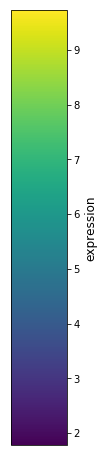

In [32]:
sID_hex_map, cbar = convert_expression_vals_to_hex(expression_vals, generate_cbar=True)

In [33]:
len(expression_vals)

117

In [34]:
pd.Series(expression_vals).describe()

count    117.000000
mean       6.663306
std        1.679248
min        1.775125
25%        5.747960
50%        7.237852
75%        7.824601
max        9.724320
dtype: float64

In [35]:
expression_lookup.head()

,structure,id,expression,hex_color
0,CA1 field,12892,9.460005,#eae51a
1,CA1 field,4254,9.460005,#eae51a
2,CA1 field,4263,9.460005,#eae51a
3,CA2 field,12893,9.724320,#fde725
4,CA2 field,4255,9.724320,#fde725


In [36]:
svg_output = modify_structure_color(human_diagram, expression_lookup, 'GABRA5.svg')

hex colour is #63cb5f
stroke:black;fill:#63cb5f
hex colour is #69cd5b
stroke:black;fill:#69cd5b
hex colour is #58c765
stroke:black;fill:#58c765
hex colour is #5cc863
stroke:black;fill:#5cc863
hex colour is #54c568
stroke:black;fill:#54c568
hex colour is #5ac864
stroke:black;fill:#5ac864
hex colour is #69cd5b
stroke:black;fill:#69cd5b
hex colour is #7ad151
stroke:black;fill:#7ad151
hex colour is #6ece58
stroke:black;fill:#6ece58
hex colour is #8bd646
stroke:black;fill:#8bd646
hex colour is #6ece58
stroke:black;fill:#6ece58
hex colour is #52c569
stroke:black;fill:#52c569
hex colour is #4ac16d
stroke:black;fill:#4ac16d
hex colour is #46c06f
stroke:black;fill:#46c06f
hex colour is #7ad151
stroke:black;fill:#7ad151
hex colour is #7ad151
stroke:black;fill:#7ad151
hex colour is #7ad151
stroke:black;fill:#7ad151
hex colour is #84d44b
stroke:black;fill:#84d44b
hex colour is #4ac16d
stroke:black;fill:#4ac16d
hex colour is #56c667
stroke:black;fill:#56c667
hex colour is #28ae80
stroke:black;fill:

In [37]:
svg_expression_vals = pd.Series(expression_vals, name='exp').reset_index().rename(columns={'index': 'id'})

In [39]:
expression_vals

{4010: 7.175775158356251,
 4021: 7.706519505887698,
 4028: 7.4215774124042255,
 4038: 7.551385144590597,
 4041: 7.495124297536298,
 4044: 7.617225268846919,
 4047: 7.9102128653686945,
 4050: 7.887785095030082,
 4053: 7.830979188990402,
 4056: 8.058210907716099,
 4059: 7.603661713889976,
 4062: 8.178274915957044,
 4065: 8.274378178562495,
 4068: 8.748001101648708,
 4071: 7.0644054011865025,
 4078: 7.824600727914226,
 4085: 6.986863385037216,
 4096: 7.003321738039876,
 4104: 7.379635215729816,
 4111: 7.237851883209373,
 4118: 7.1299277987370235,
 4125: 7.241366016700198,
 4133: 7.5040237698580246,
 4140: 7.606695175946344,
 4147: 7.755863999989646,
 4156: 8.020551087256822,
 4165: 7.4607958977472535,
 4168: 7.339888084542438,
 4171: 7.274358329156806,
 4174: 8.05566864645924,
 4177: 7.894219070865401,
 4181: 6.305029709381152,
 4186: 6.410463212717964,
 4187: 6.256269591127502,
 4193: 6.597185468898162,
 4194: 6.305123370385836,
 4198: 7.193707821936487,
 4205: 6.844309475381066,
 4212: 

In [38]:
expression_lookup

,structure,id,expression,hex_color
0,CA1 field,12892,9.460005,#eae51a
1,CA1 field,4254,9.460005,#eae51a
2,CA1 field,4263,9.460005,#eae51a
3,CA2 field,12893,9.724320,#fde725
4,CA2 field,4255,9.724320,#fde725
5,CA2 field,4264,9.724320,#fde725
6,CA3 field,12894,9.069379,#cae11f
7,CA3 field,4256,9.069379,#cae11f
8,CA3 field,4265,9.069379,#cae11f
9,CA4 field,12895,8.384222,#93d741


In [40]:
expression_table = pd.Series(expression_vals, name='exp').reset_index().rename(columns={'index': 'id'}).merge(svg_info, on='id')

In [42]:
expression_table.shape

(117, 3)

In [43]:
expression_table.sort_values('exp', ascending=False).to_csv('human_diagram_GABRA5_expression.csv', index=None)

In [27]:
#adult_exp.loc['GABRA5', :].to_csv('HBA_GABRA5_expression.csv')

In [48]:
exp_by_area.loc[:, 'GABRA5'].to_csv('HBA_GABRA5_expression.csv')

structure_name
CA1 field                                           9.460005
CA2 field                                           9.724320
CA3 field                                           9.069379
CA4 field                                           8.384222
Crus I, lateral hemisphere                          1.832068
Crus I, paravermis                                  1.887136
Crus II, lateral hemisphere                         1.795684
Crus II, paravermis                                 1.722494
Edinger-Westphal nucleus                            4.455971
Heschl's gyrus                                      7.460796
I-II                                                1.749127
III                                                 1.843054
III, lateral hemisphere                             1.664360
III, paravermis                                     1.822341
IV                                                  1.769986
IV, lateral hemisphere                              1.779196
IV, parav